In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Generate Mass and stiffnes matrices

def fem_solver(n, L=1.0):
    h = L/n # step size
    N = n+1 # Number of nodes
    M = np.zeros((N,N))
    x = np.linspace(0,1,N)

    for i in range(N):
        if i==0 or i==N-1:
            M[i,i] = 2
        else:
            M[i,i] = 4
        if i < N-1:
            M[i,i+1] = M[i+1,i] = 1
    
    M *= h/6

    K = np.zeros((N,N))
    for i in range(N):
        if i==0 or i==N-1:
            K[i,i] = 1
        else:
            K[i,i] = 2
        if i < N-1:
            K[i,i+1] = K[i+1,i] = -1
    
    K *= 1/h

    # F = np.zeros(N)
    # def rhs(x):
    #     return (1 + np.pi**2) * np.cos(np.pi*x)

    
    def rhs(x):
        u = np.cos(np.pi * x)
        return (np.pi**4 + np.pi**2 + 1) * u 

    F = rhs(x)

    F = M @ F
    # F = np.zeros_like(F)
    return M, K, F, h

M, K, F,h = fem_solver(n=4)
print("Solution coefficients a:\n", (M/(h/6)).astype(int))
print("Solution coefficients a:\n", M)
print("Solution coefficients a:\n", F)


Solution coefficients a:
 [[2 1 0 0 0]
 [1 4 1 0 0]
 [0 1 4 1 0]
 [0 0 1 4 1]
 [0 0 0 1 2]]
Solution coefficients a:
 [[0.08333333 0.04166667 0.         0.         0.        ]
 [0.04166667 0.16666667 0.04166667 0.         0.        ]
 [0.         0.04166667 0.16666667 0.04166667 0.        ]
 [0.         0.         0.04166667 0.16666667 0.04166667]
 [0.         0.         0.         0.04166667 0.08333333]]
Solution coefficients a:
 [ 1.22134163e+01  1.72723789e+01  1.54911552e-15 -1.72723789e+01
 -1.22134163e+01]


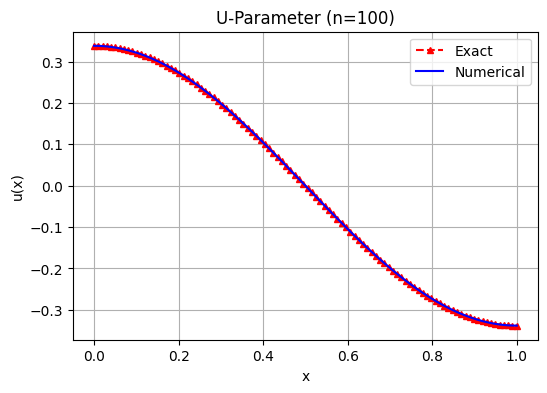

U Error (L2, H1) = (1.5994e-04, 5.0247e-04)


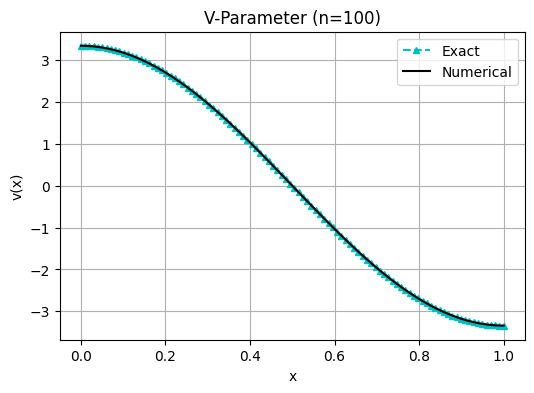

V Error (L2, H1) = (1.3803e-03, 4.3366e-03)


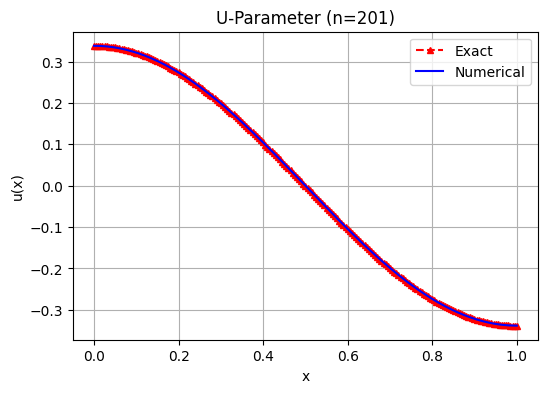

U Error (L2, H1) = (1.2891e-04, 4.0499e-04)


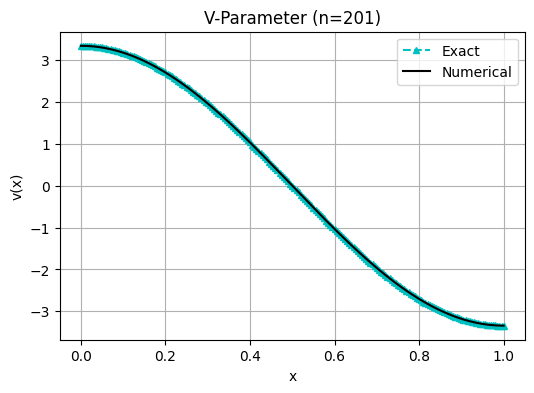

V Error (L2, H1) = (1.2237e-03, 3.8445e-03)


In [15]:
t = 0               # Start time
dt = 0.00001        # Time step size
step_sizes = [100, 201]   # Mesh refinements (number of spatial points)
T = 0.01            # Final simulation time

# Constant derived from the PDE coefficients (for analytical/exact solution)
c = (np.pi**4 + np.pi**2 + 1)

# Loop over each mesh refinement level
for n in step_sizes:
    t = 0   # Reset time for each mesh
    x = np.linspace(0, 1, n)  # Create spatial grid points in [0,1]

    # Initial conditions for u and v at t=0 (exact/analytical expressions)
    u = np.exp(-c*t) * np.cos(np.pi*x)
    v = -np.pi**2 * u

    # Initialize source term vector (right-hand side)
    F = np.zeros(n)

    # Call finite element solver setup function (user-defined elsewhere)
    # Returns Mass matrix (M), Stiffness matrix (K), and grid spacing (h)
    M, K, _, h = fem_solver(n - 1)

    # Time-stepping loop until final time T
    while t < T:
        # Compute exact/analytical solutions at current time
        u_e = np.exp(-c*t) * np.cos(np.pi*x)
        v_e = (np.pi**2) * u_e

        # Construct system matrices for the two coupled PDE equations
        a1 = K + (1 + 1.0/dt) * M   
        b1 = K 
        F1 = M @ F + (1.0/dt) * M @ u  

        F2 = np.zeros_like(F1)    

        a2 = K                   
        b2 = -M                     

        # Build the block system matrix for both u and v together
        A1 = np.block([
            [b2, a2],   # First equation row blocks
            [b1, a1]    # Second equation row blocks
        ])

        # Combine right-hand side vectors into one column
        F_res = np.array([F2, F1]).flatten()

        # Solve the coupled linear system: [A1]{ans} = {F_res}
        ans = np.linalg.solve(A1, F_res)

        # Extract numerical solutions for v and u
        v_num = ans[:n]
        u_num = ans[n:]

        # Update variables for the next time step
        u = u_num
        v = v_num

        # Compute pointwise difference between exact and numerical solutions
        u_err = u_e - u_num
        v_err = v_e - v_num

        # Compute L2 and H1 norms of errors using FEM matrices
        u_err_L2 = np.sqrt(u_err.T @ M @ u_err)
        u_err_H1 = np.sqrt(u_err.T @ K @ u_err)

        v_err_L2 = np.sqrt(v_err.T @ M @ v_err)
        v_err_H1 = np.sqrt(v_err.T @ K @ v_err)

        # Advance time
        t += dt

    # ----------------------------- Visualization -----------------------------

    # Plot numerical vs exact solution for u
    plt.figure(figsize=(6, 4))
    plt.plot(x, u_e, 'r^--', label='Exact', markersize=5)
    plt.plot(x, u_num, label='Numerical', color='blue')
    plt.legend()
    plt.grid(True)
    plt.title(f"U-Parameter (n={n})")
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.show()
    print(f"U Error (L2, H1) = ({u_err_L2:.4e}, {u_err_H1:.4e})")

    # Plot numerical vs exact solution for v
    plt.figure(figsize=(6, 4))
    plt.plot(x, v_e, 'c^--', label='Exact', markersize=5)
    plt.plot(x, v_num, label='Numerical', color='black')
    plt.legend()
    plt.grid(True)
    plt.title(f"V-Parameter (n={n})")
    plt.xlabel('x')
    plt.ylabel('v(x)')
    plt.show()
    print(f"V Error (L2, H1) = ({v_err_L2:.4e}, {v_err_H1:.4e})")



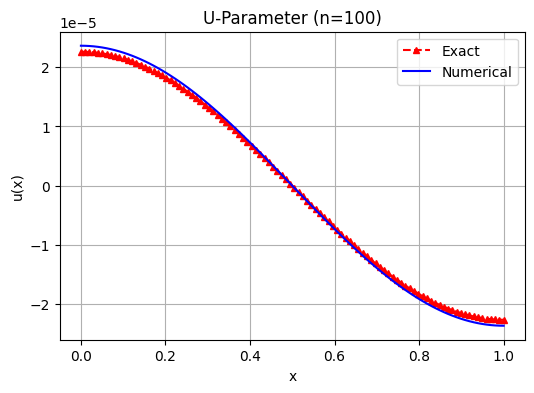

U Error (L2, H1) = (7.1269e-07, 2.2391e-06)


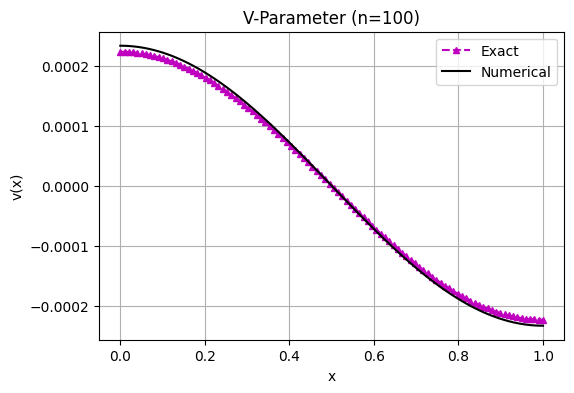

V Error (L2, H1) = (7.0478e-06, 2.2142e-05)


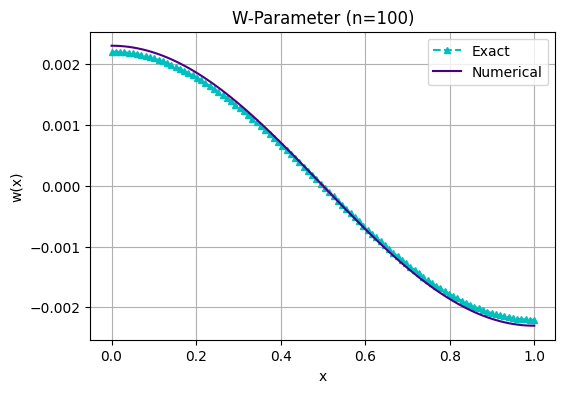

W Error (L2, H1) = (6.9696e-05, 2.1897e-04)


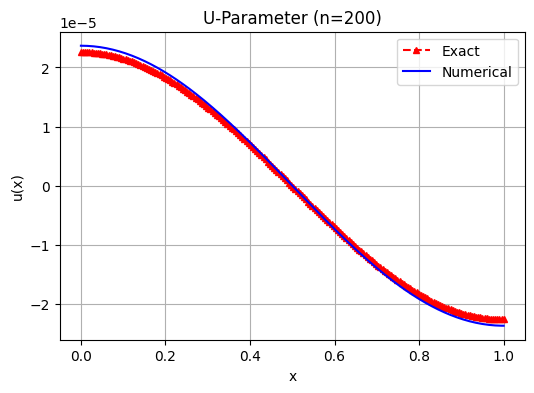

U Error (L2, H1) = (7.4505e-07, 2.3407e-06)


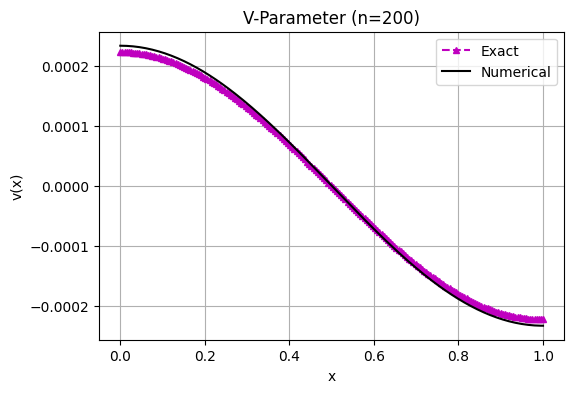

V Error (L2, H1) = (7.3568e-06, 2.3112e-05)


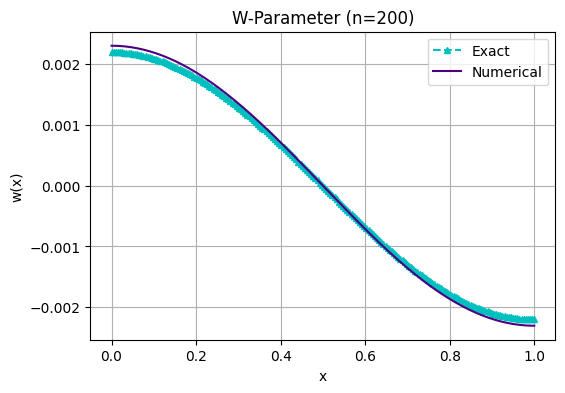

W Error (L2, H1) = (7.2642e-05, 2.2821e-04)


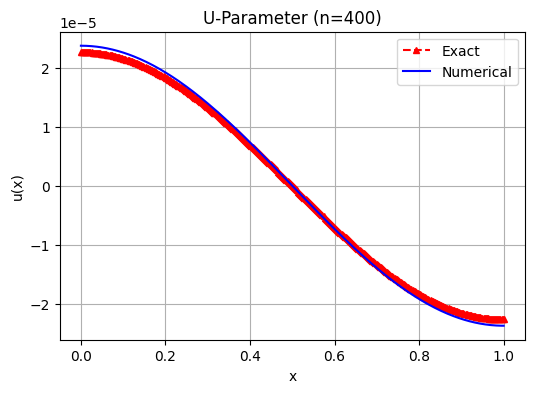

U Error (L2, H1) = (7.5305e-07, 2.3658e-06)


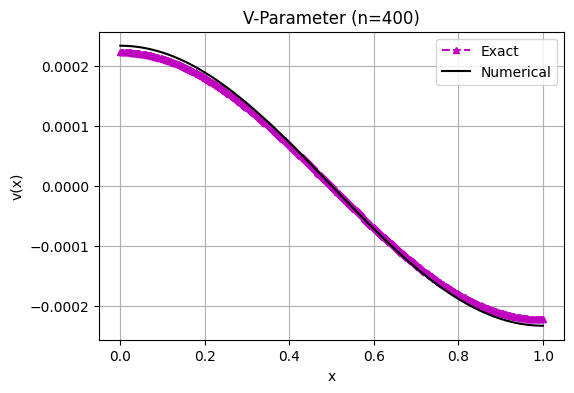

V Error (L2, H1) = (7.4332e-06, 2.3352e-05)


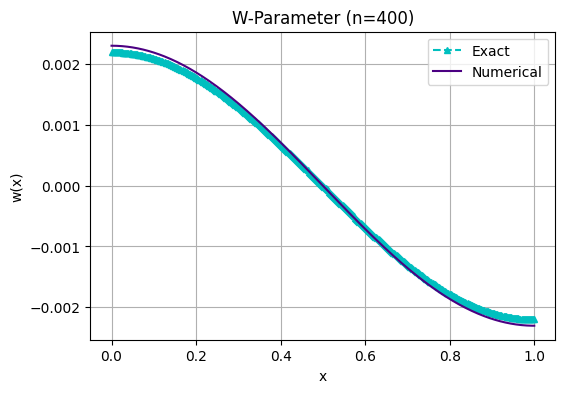

W Error (L2, H1) = (7.3371e-05, 2.3050e-04)


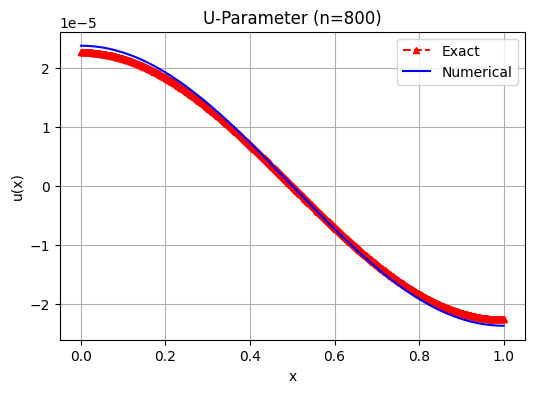

U Error (L2, H1) = (7.5504e-07, 2.3720e-06)


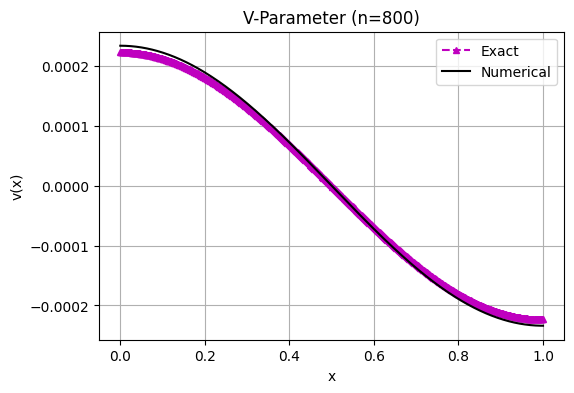

V Error (L2, H1) = (7.4522e-06, 2.3412e-05)


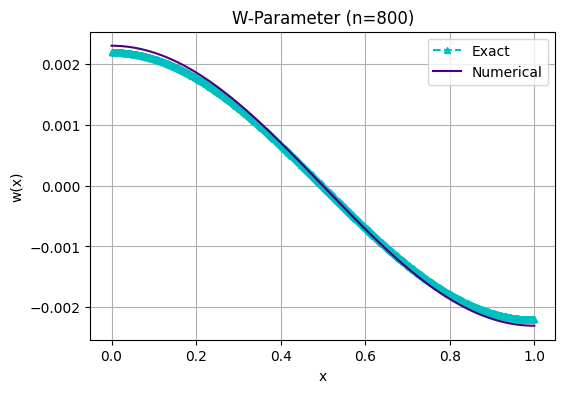

W Error (L2, H1) = (7.3552e-05, 2.3107e-04)


In [34]:
t = 0               # Start time
dt = 0.00001        # Time step size
step_sizes = [100, 200, 400, 800]   # Mesh refinements (number of spatial points)
T = 0.01            # Final simulation time

# Constant derived from the PDE coefficients (for analytical/exact solution)
c = (np.pi**6 + np.pi**4 + np.pi**2 + 1)

# Loop over each mesh refinement level
for n in step_sizes:
    t = 0   # Reset time for each mesh
    x = np.linspace(0, 1, n)  # Create spatial grid points in [0,1]

    # Initial conditions for u and v at t=0 (exact/analytical expressions)
    u = np.exp(-c*t) * np.cos(np.pi*x)
    v = -np.pi**2 * u
    w = -np.pi**2 * v

    # Initialize source term vector (right-hand side)
    F = np.zeros(n)

    # Call finite element solver setup function (user-defined elsewhere)
    # Returns Mass matrix (M), Stiffness matrix (K), and grid spacing (h)
    M, K, _, h = fem_solver(n - 1)

    # Time-stepping loop until final time T
    while t < T:
        # Compute exact/analytical solutions at current time
        u_e = np.exp(-c*t) * np.cos(np.pi*x)
        v_e = np.exp(-c*t) * (np.pi**2) * np.cos(np.pi*x)
        w_e = (np.pi**2) * v_e

        # Construct system matrices for the two coupled PDE equations
        a1 = (1 + 1.0/dt) * M   
        b1 = M 
        c1 = K + M

        F1 = M @ F + (1.0/dt) * M @ u  

        F2 = F3 = np.zeros_like(F1)    

        a2 = -K         
        b2 = M                     
        c2 = np.zeros_like(M)

        a3 = np.zeros_like(M)
        b3 = -K
        c3 = M

        # Build the block system matrix for both u and v together
        A1 = np.block([
            [a3, b3, c3],
            [a2, b2, c2], 
            [a1, b1, c1]   
            ])

        # Combine right-hand side vectors into one column
        F_res = np.array([F3, F2, F1]).flatten()

        # Solve the coupled linear system: [A1]{ans} = {F_res}
        ans = np.linalg.solve(A1, F_res)

        # Extract numerical solutions for v and u
        u_num = ans[:n]
        v_num = ans[n:2*n]
        w_num = ans[2*n:]

        # Update variables for the next time step
        u = u_num
        v = v_num
        w = w_num

        # Compute pointwise difference between exact and numerical solutions
        u_err = u_e - u_num
        v_err = v_e - v_num
        w_err = w_e - w_num


        # Compute L2 and H1 norms of errors using FEM matrices
        u_err_L2 = np.sqrt(u_err.T @ M @ u_err)
        u_err_H1 = np.sqrt(u_err.T @ K @ u_err)

        v_err_L2 = np.sqrt(v_err.T @ M @ v_err)
        v_err_H1 = np.sqrt(v_err.T @ K @ v_err)
        
        w_err_L2 = np.sqrt(w_err.T @ M @ w_err)
        w_err_H1 = np.sqrt(w_err.T @ K @ w_err)

        # Advance time
        t += dt

    # ----------------------------- Visualization -----------------------------

    # Plot numerical vs exact solution for u
    plt.figure(figsize=(6, 4))
    plt.plot(x, u_e, 'r^--', label='Exact', markersize=5)
    plt.plot(x, u_num, label='Numerical', color='blue')
    plt.legend()
    plt.grid(True)
    plt.title(f"U-Parameter (n={n})")
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.show()
    print(f"U Error (L2, H1) = ({u_err_L2:.4e}, {u_err_H1:.4e})")

    # Plot numerical vs exact solution for v
    plt.figure(figsize=(6, 4))
    plt.plot(x, v_e, 'm^--', label='Exact', markersize=5)
    plt.plot(x, v_num, label='Numerical', color='black')
    plt.legend()
    plt.grid(True)
    plt.title(f"V-Parameter (n={n})")
    plt.xlabel('x')
    plt.ylabel('v(x)')
    plt.show()
    print(f"V Error (L2, H1) = ({v_err_L2:.4e}, {v_err_H1:.4e})")
    
    # Plot numerical vs exact solution for w
    plt.figure(figsize=(6, 4))
    plt.plot(x, w_e, 'c^--', label='Exact', markersize=5)
    plt.plot(x, w_num, label='Numerical', color='indigo')
    plt.legend()
    plt.grid(True)
    plt.title(f"W-Parameter (n={n})")
    plt.xlabel('x')
    plt.ylabel('w(x)')
    plt.show()
    print(f"W Error (L2, H1) = ({w_err_L2:.4e}, {w_err_H1:.4e})")

